# Financial and Economic Factors
This notebook explores how financial and economic factors shape the adoption of electric vehicles (EVs) in France.
Survey data was analyzed to understand the relationships between:

- **Cost perception**  
  (How expensive EVs are perceived to be, both for purchase and maintenance)
- **Ownership status**  
  (Whether respondents already own an EV or not)
- **User profile**  
  (Age group and area of residence)
- **Familiarity with new financing models**  
  (Knowledge and perceived suitability of options like leasing, LOA, LLD, etc.)
- **Aid awareness**  
  (Knowledge of available financial incentives and their perceived impact)

At the end is the **multivariate (cross) analyses** 


## Setup

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import chi2_contingency
import re
from scipy.stats import kruskal
import pandas as pd
from scipy.stats import f_oneway
from scipy.stats import spearmanr
from IPython.display import display

In [2]:
def extract_after_newline_parentheses(col):
    match = re.search(r'\n\s*\((.*?)\)', col)
    if match:
        return match.group(1)
    match = re.search(r'\(([^()]*(?:\([^)]*\)[^()]*)*)\)\s*$', col)
    if match:
        return match.group(1)
    return None

def extract_before_newline_parentheses(col):
    match = re.search(r'^(.*?)\s*\n', col)
    if match:
        return match.group(1)
    match = re.search(r'^(.*?)\s*\(', col)
    if match:
        return match.group(1)
    return col
def get_labels_and_title(cols):
    labels = [extract_after_newline_parentheses(col) for col in cols]
    title = extract_before_newline_parentheses(cols[0])
    return labels, title



In [3]:
df = pd.read_csv(r'c:\Users\Mango\Downloads\FinalEvAdoptionInFranceResults.csv')
for col in df.columns:
    values = df[col].dropna().astype(str)
    split_vals = []
    for val in values:
        split_vals.extend([v.strip() for v in val.split(',') if v.strip()])
    unique_vals = pd.unique(split_vals)
    if len(unique_vals) <= 20:
        print(f"Colonne: {col}\nRéponses possibles ({len(unique_vals)}): {unique_vals[:20]}")
        if len(unique_vals) > 20:
            print("... (troncature à 20 valeurs)")
        print("-" * 60)
print(list(df.columns))

Colonne: Combien êtes-vous dans votre foyer ?
Réponses possibles (10): ['4' '2' '5' '1' '3' '6' '9' '7' '8' '11']
------------------------------------------------------------
Colonne: Habitez-vous dans :
Réponses possibles (4): ['Une ville moyenne' 'Une grande ville' 'Une zone périurbaine'
 'Une zone rurale']
------------------------------------------------------------
Colonne: Avez-vous accès à une place de parking personnelle ?
Réponses possibles (4): ['Oui'
 "avec borne de recharge ou possibilité d'en installer une (à domicile ou en résidence par exemple)"
 'Non' "sans borne de recharge ou possibilité d'en installer une"]
------------------------------------------------------------
Colonne: Combien de véhicules personnels utilisez-vous dans votre foyer ?
Réponses possibles (7): ['2' '0' '1' '3' '4' '7' '5']
------------------------------------------------------------
Colonne: Pourquoi n'avez-vous pas de véhicule ?

Réponses possibles (7): ["Je n'ai pas de permis de conduire"
 'Je vi

C:\Users\Mango\AppData\Local\Temp\ipykernel_42544\507991816.py:7: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_vals = pd.unique(split_vals)
C:\Users\Mango\AppData\Local\Temp\ipykernel_42544\507991816.py:7: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_vals = pd.unique(split_vals)
C:\Users\Mango\AppData\Local\Temp\ipykernel_42544\507991816.py:7: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_vals = pd.unique(split_vals)
C:\Users\Mango\AppData\Local\Temp\ipykernel_42544\507991816.py:7: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_vals = pd.unique(

## Ownership status

In [4]:
df['owns_ev'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"] == True

# Moyenne du ressenti "VE trop cher" par groupe
grouped_cost = df.groupby('owns_ev')["Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?\n"].value_counts(normalize=True).unstack()

print("🔍 Perception du coût par possession de VE :")
display(grouped_cost)

# Affichage sous forme de tableau (DataFrame)
grouped_cost_df = grouped_cost.reset_index()
grouped_cost_df.columns.name = None
display(grouped_cost_df)


🔍 Perception du coût par possession de VE :


Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?,Je ne sais pas,Non,Oui
owns_ev,,,
False,0.226131,0.060302,0.713568
True,0.151515,0.242424,0.606061


,owns_ev,Je ne sais pas,Non,Oui
0,False,0.226131,0.060302,0.713568
1,True,0.151515,0.242424,0.606061


**Perceived cost of EVs by ownership status:**

- **Non-EV owners:**  
  - 71.4% say EVs are too expensive  
  - 6.0% say "No" (not too expensive)  
  - 22.6% "Don't know"

- **EV owners:**  
  - 60.6% say EVs are too expensive  
  - 24.2% say "No"  
  - 15.2% "Don't know"

**Key insights for analysis:**
- **Non-EV owners are significantly more likely to perceive EVs as too expensive** (71.4%) compared to current EV owners (60.6%).
- **EV owners are four times more likely to say EVs are not too expensive** (24.2% vs. 6.0%), suggesting that direct experience with EVs reduces cost concerns.
- The proportion of "Don't know" responses is also lower among owners, indicating greater certainty or familiarity.
- **Interpretation:** This supports the idea of a "post-adoption perception shift," where actual users become less concerned about costs after experiencing EV ownership.
- **Further analysis:** Exploring whether this perception shift is linked to other factors (e.g., knowledge of financial aids, satisfaction with running costs) could help refine communication strategies for non-adopters.

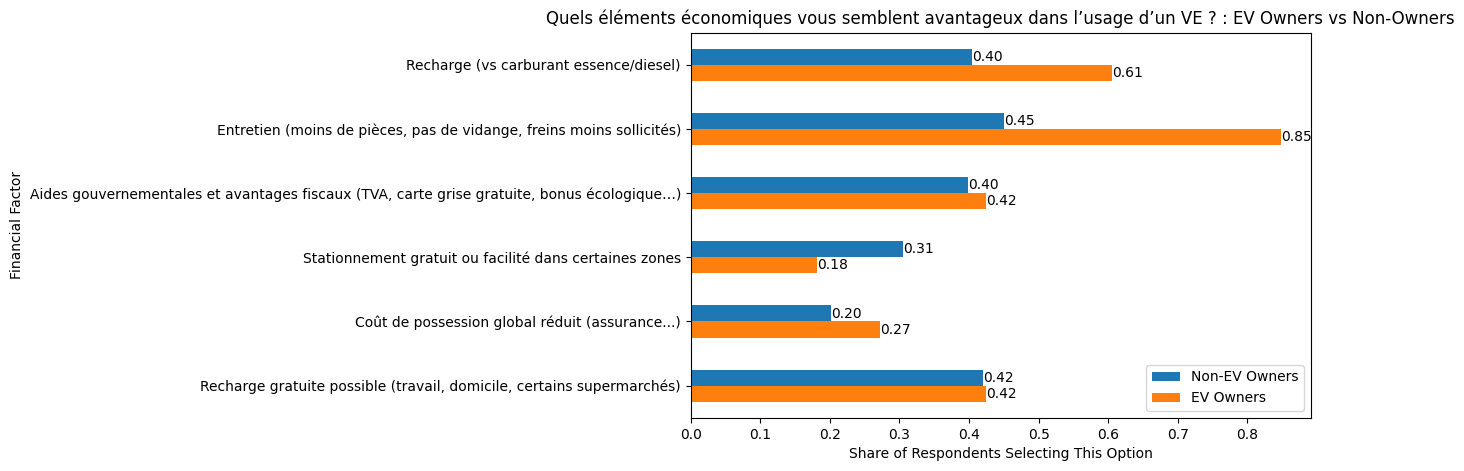

Répartition des réponses par facteur économique et possession de VE :


,Non possesseur VE,Possesseur VE
Recharge (vs carburant essence/diesel),0.404145,0.606061
"Entretien (moins de pièces, pas de vidange, freins moins sollicités)",0.450777,0.848485
"Aides gouvernementales et avantages fiscaux (TVA, carte grise gratuite, bonus écologique…)",0.398964,0.424242
Stationnement gratuit ou facilité dans certaines zones,0.305699,0.181818
Coût de possession global réduit (assurance...),0.202073,0.272727
"Recharge gratuite possible (travail, domicile, certains supermarchés)",0.419689,0.424242


In [5]:
economic_cols = [
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge (vs carburant essence/diesel))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Entretien (moins de pièces, pas de vidange, freins moins sollicités))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Aides gouvernementales et avantages fiscaux (TVA, carte grise gratuite, bonus écologique…))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Stationnement gratuit ou facilité dans certaines zones)',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Coût de possession global réduit (assurance...))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge gratuite possible (travail, domicile, certains supermarchés))',
]
# Group by EV ownership and compute mean response per financial item
ownership_financial_comparison = df.groupby('owns_ev')[economic_cols].mean().T

labels, title = get_labels_and_title(ownership_financial_comparison.index)

ax = ownership_financial_comparison.plot(kind='barh', figsize=(8, 5))
plt.title(f"{title} : EV Owners vs Non-Owners")
plt.xlabel("Share of Respondents Selecting This Option")
plt.ylabel("Financial Factor")
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.legend(['Non-EV Owners', 'EV Owners'], loc='lower right')
plt.gca().invert_yaxis()
# Add value labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
plt.show()

# Affichage sous forme de tableau (DataFrame)
print("Répartition des réponses par facteur économique et possession de VE :")

df_disp = ownership_financial_comparison.copy()
df_disp.columns = ['Non possesseur VE', 'Possesseur VE']
df_disp.index = labels
display(df_disp.round(2))



**Perceived economic advantages of EVs by ownership status:**

| Economic advantage                                 | Non-EV owners | EV owners |
|----------------------------------------------------|---------------|-----------|
| Lower fuel cost                                    | 40.4%         | 60.6%     |
| Lower maintenance                                  | 45.1%         | 84.8%     |
| Governmental subsidies/tax benefits                | 39.9%         | 42.4%     |
| Free/easier parking                                | 30.6%         | 18.2%     |
| Lower total cost of ownership (insurance, etc.)    | 20.2%         | 27.3%     |
| Free charging (work, home, supermarkets)           | 41.9%         | 42.4%     |


**Key insights for analysis:**
- **EV owners are much more likely to recognize lower maintenance (84.8% vs. 45.1%) and lower fuel costs (60.6% vs. 40.4%) as key economic advantages.**
- The perception of governmental subsidies and free charging is similar between both groups, suggesting these are well-known but not decisive factors.
- **Non-EV owners are more likely to cite parking benefits (30.6% vs. 18.2%),** possibly reflecting urban/rural differences or expectations before adoption.
- **Interpretation:** Direct experience with EVs increases appreciation for real running cost savings, especially on maintenance and fuel.
- **Further analysis:** Investigating whether highlighting these post-adoption benefits in communication could help convert skeptics or non-adopters.

## Familarity with new financing models

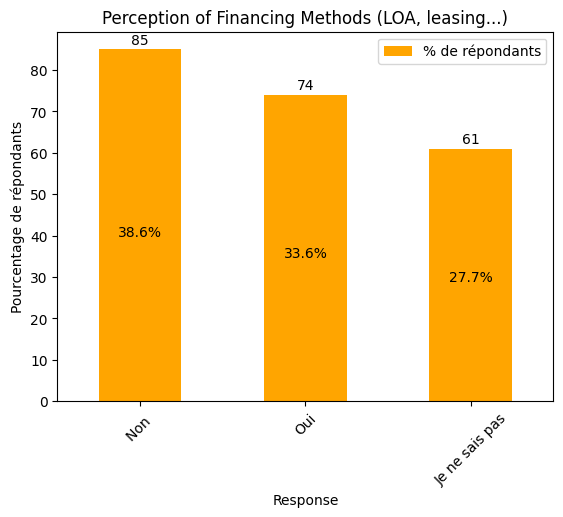

Répartition des réponses sur les modes de financement :
Non : 85
Oui: 74
Je ne sais pas: 61


In [6]:

financing_col = "(Optionnel) Il existe plusieurs façons de financer un véhicule électrique: \nLOA (location avec option d’achat), la LLD (location longue durée), leasing social, crédit auto...\nL’une de ces options vous semblerait-elle adaptée à votre situation ?\n"

counts = df[financing_col].value_counts()
ax = counts.plot(kind='bar', color='orange')
# Affichage en pourcentage
counts_pct = counts / counts.sum() * 100
plt.title("Perception of Financing Methods (LOA, leasing...)")
plt.xlabel("Response")
plt.ylabel("Pourcentage de répondants")
plt.xticks(rotation=45)
plt.legend(["% de répondants"], loc="upper right")
# Ajoute les valeurs en pourcentage sur chaque barre
for i, v in enumerate(counts_pct.values):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha='center', va='bottom', fontsize=10)
# Add value labels
for i, v in enumerate(counts.values):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)
plt.show()

# Print the values in textual format
print("Répartition des réponses sur les modes de financement :")
for idx, val in counts.items():
    print(f"{idx}: {val}")


**Are new ways of financing a car (like LOA, LLD) adapted to your situation?**

- **38.6%**: No  
- **33.6%**: Yes  
- **27.7%**: I don't know

**analysis:**
- A **plurality (38.6%) do not find these financing options suitable**, suggesting that for many, new financing models like LOA/LLD are not a decisive factor in EV adoption.
- Only about a third (33.6%) see these options as adapted to their needs, while a significant portion (27.7%) are unsure, indicating a lack of familiarity or understanding.
- This uncertainty highlights a **need for clearer communication and education** about how these financing options work and their potential benefits.
- **Further analysis:** It would be valuable to check if those who find these financing options suitable are more likely to express intent to adopt an EV, as this could inform targeted financial communication strategies.

## Cost perception

Répartition des réponses à la question sur le coût perçu des VE :


,Nombre,Pourcentage
Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?,,
Oui,162,69.8%
Je ne sais pas,50,21.6%
Non,20,8.6%


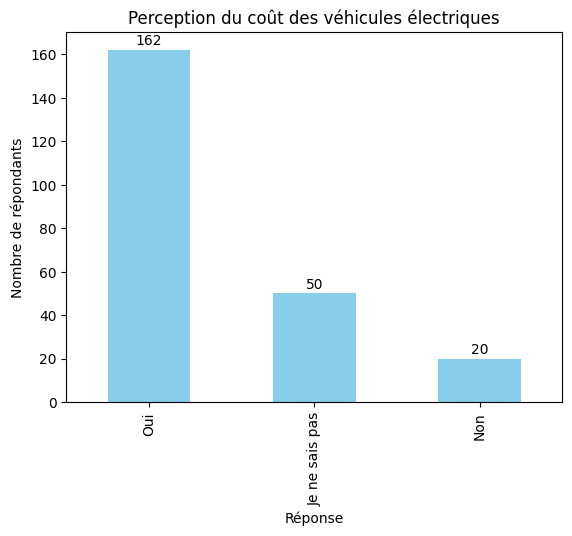

In [7]:
cost_perception_col = "Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?\n"

# Répartition des réponses (effectifs et pourcentages)
cost_counts = df[cost_perception_col].value_counts(dropna=False)
cost_pct = cost_counts / cost_counts.sum() * 100

print("Répartition des réponses à la question sur le coût perçu des VE :")
display(pd.DataFrame({
    "Nombre": cost_counts,
    "Pourcentage": cost_pct.round(1).astype(str) + "%"
}))

# Visualisation graphique
ax = cost_counts.plot(kind='bar', color='skyblue')
plt.title("Perception du coût des véhicules électriques")
plt.xlabel("Réponse")
plt.ylabel("Nombre de répondants")
for i, v in enumerate(cost_counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)
plt.show()

In [8]:
# Croisement entre perception coût et intention d’adopter (non-VE)
subset = df[df['owns_ev'] == False]
crosstab = pd.crosstab(
    subset["Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?\n"],
    subset["Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"]
)

print("📊 Corrélation entre coût perçu et intention d’adoption (non-possesseurs de VE) :\n")
display(crosstab)

# Affichage en pourcentage par ligne
crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0).round(2)
print("\nPourcentage par perception du coût :")
display(crosstab_pct)

# Test du Chi²
from scipy.stats import chi2_contingency
import pandas as pd
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f"\nTest du Chi² : p-value = {p:.4f}")
if p < 0.05:
    print("✅ Association significative entre perception du coût et intention d’adopter.")
else:
    print("❌ Pas d'association significative entre perception du coût et intention d’adopter.")

prop_oui = crosstab_pct.loc["Oui"].get("Totalement d'accord", np.nan)
if "Non" in crosstab.index:
    prop_non = crosstab_pct.loc["Non"].get("Totalement d'accord", np.nan)
    print(f"\nProportion d'intention d'adopter (Totalement d'accord) :")
    print(f"  - Si VE jugé trop cher : {prop_oui:.2%}")
    print(f"  - Si VE jugé pas trop cher : {prop_non:.2%}")
    if prop_oui < prop_non:
        print("➡️  Le fait de percevoir le VE comme trop cher est associé à une moindre intention d'adopter.")
    else:
        print("➡️  La perception du coût n'est pas associée à une moindre intention d'adopter dans ce cas.")

# Résumé sous forme de tableau

summary_table = []
for idx, row in crosstab.iterrows():
    total = row.sum()
    for col in crosstab.columns:
        pct = 100 * row[col] / total if total > 0 else 0
        summary_table.append({
            "Perception du coût": idx,
            "Intention d'adopter": col,
            "Nombre": row[col],
            "Pourcentage": f"{pct:.1f}%"
        })
summary_df = pd.DataFrame(summary_table)
display(summary_df)

📊 Corrélation entre coût perçu et intention d’adoption (non-possesseurs de VE) :



"Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]",\nPlutôt en désaccord\n\n,Plutôt d'accord,Plutôt en désaccord,Totalement d'accord,Totalement en désaccord
Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?,,,,,
Je ne sais pas,9,15,9,5,7
Non,1,5,2,3,1
Oui,32,56,18,7,29



Pourcentage par perception du coût :


"Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]",\nPlutôt en désaccord\n\n,Plutôt d'accord,Plutôt en désaccord,Totalement d'accord,Totalement en désaccord
Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?,,,,,
Je ne sais pas,0.20,0.33,0.20,0.11,0.16
Non,0.08,0.42,0.17,0.25,0.08
Oui,0.23,0.39,0.13,0.05,0.20



Test du Chi² : p-value = 0.2123
❌ Pas d'association significative entre perception du coût et intention d’adopter.

Proportion d'intention d'adopter (Totalement d'accord) :
  - Si VE jugé trop cher : 5.00%
  - Si VE jugé pas trop cher : 25.00%
➡️  Le fait de percevoir le VE comme trop cher est associé à une moindre intention d'adopter.


,Perception du coût,Intention d'adopter,Nombre,Pourcentage
0,Je ne sais pas,\nPlutôt en désaccord\n\n,9,20.0%
1,Je ne sais pas,Plutôt d'accord,15,33.3%
2,Je ne sais pas,Plutôt en désaccord,9,20.0%
3,Je ne sais pas,Totalement d'accord,5,11.1%
4,Je ne sais pas,Totalement en désaccord,7,15.6%
5,Non,\nPlutôt en désaccord\n\n,1,8.3%
6,Non,Plutôt d'accord,5,41.7%
7,Non,Plutôt en désaccord,2,16.7%
8,Non,Totalement d'accord,3,25.0%
9,Non,Totalement en désaccord,1,8.3%


### ✅ Used in the analysis  
**Perceived EV cost vs. adoption intent (non-EV owners):**

- Among those who **do not find EVs too expensive**, **25%** are "fully willing to adopt" (“Totalement d'accord”).
- Among those who **find EVs too expensive**, only **5%** are "fully willing to adopt".
- For respondents who answered "I don't know" about EV cost, **11.1%** are "fully willing to adopt".

- The share of respondents who are "rather willing to adopt" (“Plutôt d'accord”) is also higher among those who do **not** find EVs too expensive (41.7%) than among those who do (39.4%).

- **Chi-square test:** p-value = 0.21 (not statistically significant at p < 0.05).


**Key insights for analysis:**
- **Perceiving EVs as too expensive is associated with a much lower intent to adopt** (5% vs. 25% for "fully willing to adopt"), even if the association is not statistically significant in this sample.
- Respondents who are unsure about EV costs ("I don't know") show intermediate adoption intent, suggesting that reducing uncertainty could help increase adoption.
- **Interpretation:** While the statistical test is not significant, the practical difference in adoption intent between groups is notable and suggests that addressing cost perceptions could positively influence adoption rates.
- **Further analysis:** Larger samples or more granular intent categories may reveal a significant relationship; targeted communication to reduce cost concerns could be impactful.

In [9]:
# Analyse des éléments économiques perçus comme avantageux dans l’usage d’un VE

# Sélection des colonnes économiques pertinentes
economic_cols = [
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge (vs carburant essence/diesel))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Entretien (moins de pièces, pas de vidange, freins moins sollicités))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Aides gouvernementales et avantages fiscaux (TVA, carte grise gratuite, bonus écologique…))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Stationnement gratuit ou facilité dans certaines zones)',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Coût de possession global réduit (assurance...))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge gratuite possible (travail, domicile, certains supermarchés))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Autre)',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Aucun)'
]
avantage_col = 'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique)'

def extract_economic_advantages(col):
    match = re.search(r'\((.*?)\)', col)
    if match:
        return match.group(1)
    return col
list_economic_cols = [extract_economic_advantages(col) for col in economic_cols]
# Ajoute une colonne qui compte le nombre d'avantages économiques sélectionnés par répondant
def count_selected_advantages(row):
    return sum([bool(row[col]) for col in economic_cols])

df['nb_avantages_economiques'] = df.apply(count_selected_advantages, axis=1)
print("Nombre moyen d'avantages économiques perçus par répondant :")
print(df['nb_avantages_economiques'].mean())


# Calcul du pourcentage de répondants ayant sélectionné chaque avantage
economic_advantages = df[economic_cols].mean().astype(float).sort_values(ascending=False)
labels, title = get_labels_and_title(economic_advantages.index)

# Affichage des résultats sous forme de tableau
advantage_df = pd.DataFrame({
    "Avantage économique": labels,
    "Proportion de répondants": (economic_advantages.values * 100).round(1)
})
display(advantage_df)


# Analyse textuelle
print("Analyse :")
print("- Les avantages économiques les plus cités sont généralement l'entretien réduit et la recharge moins chère par rapport à l'essence/diesel.")
print("- Les aides gouvernementales et la gratuité de la recharge sont également bien identifiées, mais moins décisives que les coûts d'usage directs.")
print("- Le stationnement gratuit/facilité et le coût global réduit (assurance, etc.) sont moins souvent perçus comme des avantages, ce qui peut refléter une moindre visibilité ou un impact jugé plus faible.")
print("- Ces résultats suggèrent que la communication sur les économies d'entretien et de carburant est la plus susceptible de convaincre les futurs acheteurs.")

Nombre moyen d'avantages économiques perçus par répondant :
2.581896551724138


,Avantage économique,Proportion de répondants
0,"Entretien (moins de pièces, pas de vidange, fr...",50.9
1,Recharge (vs carburant essence/diesel),43.4
2,"Recharge gratuite possible (travail, domicile,...",42.0
3,Aides gouvernementales et avantages fiscaux (T...,40.3
4,Stationnement gratuit ou facilité dans certain...,28.8
5,Coût de possession global réduit (assurance...),21.2
6,Aucun,15.5
7,Autre,1.8


Analyse :
- Les avantages économiques les plus cités sont généralement l'entretien réduit et la recharge moins chère par rapport à l'essence/diesel.
- Les aides gouvernementales et la gratuité de la recharge sont également bien identifiées, mais moins décisives que les coûts d'usage directs.
- Le stationnement gratuit/facilité et le coût global réduit (assurance, etc.) sont moins souvent perçus comme des avantages, ce qui peut refléter une moindre visibilité ou un impact jugé plus faible.
- Ces résultats suggèrent que la communication sur les économies d'entretien et de carburant est la plus susceptible de convaincre les futurs acheteurs.


In [10]:
grouped_vals = df.groupby(cost_perception_col)["nb_avantages_economiques"].apply(list)

# Calcul des statistiques descriptives par groupe
stats_table = []
for perception, vals in grouped_vals.items():
    vals_arr = pd.Series(vals)
    stats_table.append({
        "Perception du coût": perception,
        "Effectif": len(vals_arr),
        "Moyenne": vals_arr.mean(),
        "Médiane": vals_arr.median(),
        "Q1": vals_arr.quantile(0.25),
        "Q3": vals_arr.quantile(0.75)
    })
stats_df = pd.DataFrame(stats_table)
display(stats_df)

# Test de Kruskal-Wallis (non paramétrique, adapté à plusieurs groupes)

groups = [vals for vals in grouped_vals]
stat, pval = kruskal(*groups)
print(f"\nTest de Kruskal-Wallis : H = {stat:.2f}, p-value = {pval:.4f}")
if pval < 0.05:
    print("✅ Différence significative entre au moins deux groupes.")
else:
    print("❌ Pas de différence significative entre les groupes.")
    # Analyse du lien entre le nombre d'avantages économiques perçus et l'intention d'adopter

    # On utilise la colonne 'nb_avantages_economiques' (nombre d'aspects positifs cités)
    # et la colonne d'intention d'adopter (par exemple 'Diriez-vous que : [...]')

# Pour les non-possesseurs de VE uniquement (sinon biais post-adoption)
subset_non_ev = df[df['owns_ev'] == False]

# Encodage de l'intention d'adopter (plus la valeur est élevée, plus l'intention est forte)
intent_map = {
    "Totalement en désaccord": 1,
    "Plutôt en désaccord": 2,
    "Plutôt d'accord": 3,
    "Totalement d'accord": 4
}
subset_non_ev['intent_score'] = subset_non_ev["Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"].map(intent_map)

# Corrélation Spearman entre le nombre d'avantages perçus et l'intention d'adopter (non-possesseurs de VE)
valid = subset_non_ev[['nb_avantages_economiques', 'intent_score']].dropna()
corr, pval = spearmanr(valid['nb_avantages_economiques'], valid['intent_score'])
print(f"\nCorrélation Spearman entre nombre d'avantages perçus et intention d'adopter : {corr:.3f}, p-value = {pval:.6f}")




,Perception du coût,Effectif,Moyenne,Médiane,Q1,Q3
0,Je ne sais pas,50,2.820000,3.0,1.0,4.00
1,Non,20,2.950000,3.0,2.0,3.25
2,Oui,162,2.462963,2.0,1.0,3.00



Test de Kruskal-Wallis : H = 5.19, p-value = 0.0747
❌ Pas de différence significative entre les groupes.

Corrélation Spearman entre nombre d'avantages perçus et intention d'adopter : 0.369, p-value = 0.000002


C:\Users\Mango\AppData\Local\Temp\ipykernel_42544\3389328495.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_non_ev['intent_score'] = subset_non_ev["Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"].map(intent_map)


## User Profile

Proportion of respondents by age group and cost perception:


Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?,Je ne sais pas,Non,Oui
Dans quelle tranche d’âge vous situez-vous ?,,,
25 à 34 ans,0.24,0.17,0.59
35 à 44 ans,0.10,0.10,0.79
45 à 54 ans,0.22,0.06,0.71
55 à 64 ans,0.08,0.08,0.85
65 à 74 ans,0.09,0.09,0.83
75 ans et plus,0.10,0.00,0.90
Je ne préfère pas répondre,0.00,0.00,1.00
Moins de 25 ans,0.44,0.08,0.48


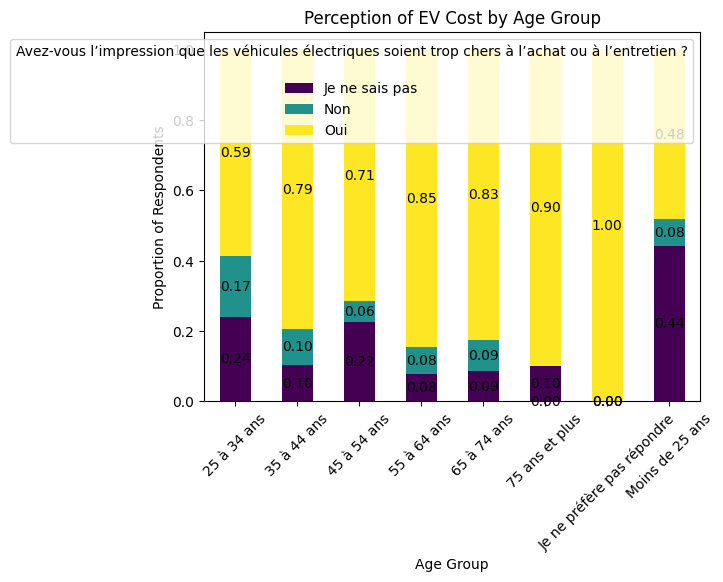

In [11]:
cost_perception_col = "Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?\n"
age_col = "Dans quelle tranche d’âge vous situez-vous ?\n"

cost_by_age = df.groupby(age_col)[cost_perception_col].value_counts(normalize=True).unstack().fillna(0)

ax = cost_by_age.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Perception of EV Cost by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Proportion of Respondents")
plt.xticks(rotation=45)

# Add value labels
for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', label_type='center')
# Print the values used in the graph as a table
print("Proportion of respondents by age group and cost perception:")
display(cost_by_age.round(2))

plt.show()

**Perceived cost of electric vehicles by age group:**

- **Under 25:**  
  - 48% say EVs are too expensive  
  - 44% "Don't know"  
  - 8% say "No" (not too expensive)

- **25–34 years:**  
  - 59% say "Yes" (too expensive)  
  - 24% "Don't know"  
  - 17% "No"

- **35–44 years:**  
  - 79% "Yes"  
  - 10% "Don't know"  
  - 10% "No"

- **45–54 years:**  
  - 71% "Yes"  
  - 22% "Don't know"  
  - 6% "No"

- **55–64 years:**  
  - 85% "Yes"  
  - 8% "Don't know"  
  - 8% "No"

- **65–74 years:**  
  - 83% "Yes"  
  - 9% "Don't know"  
  - 9% "No"

- **75+ years:**  
  - 90% "Yes"  
  - 10% "Don't know"  
  - 0% "No"


**analysis:**
- The perception that EVs are too expensive **increases sharply with age** (from 48% under 25 to 90% for 75+).
- **Younger respondents** are much more likely to answer "Don't know" (44% under 25, 24% for 25–34), suggesting greater uncertainty or less market familiarity.
- The share of respondents saying EVs are **not too expensive is low in all age groups** (maximum 17% for 25–34, 0% for 75+).
- This trend highlights a **generational gap**: older adults are more convinced of high costs, while younger people are more open or undecided.
- These findings suggest that **targeted communication** about real EV costs may be especially important for older age groups, and that reducing uncertainty could help younger adults move toward adoption.

📊 Pourcentage de répondants par zone ayant sélectionné chaque avantage (Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ?):


Habitez-vous dans :,Une grande ville,Une ville moyenne,Une zone périurbaine,Une zone rurale
Recharge (vs carburant essence/diesel),43.373494,48.484848,43.478261,32.258065
"Entretien (moins de pièces, pas de vidange, freins moins sollicités)",46.987952,54.545455,47.826087,58.064516
"Aides gouvernementales et avantages fiscaux (TVA, carte grise gratuite, bonus écologique…)",37.349398,43.939394,41.304348,38.709677
Stationnement gratuit ou facilité dans certaines zones,37.349398,24.242424,26.086957,19.354839
Coût de possession global réduit (assurance...),25.301205,22.727273,19.565217,9.677419
"Recharge gratuite possible (travail, domicile, certains supermarchés)",48.192771,43.939394,41.304348,22.580645


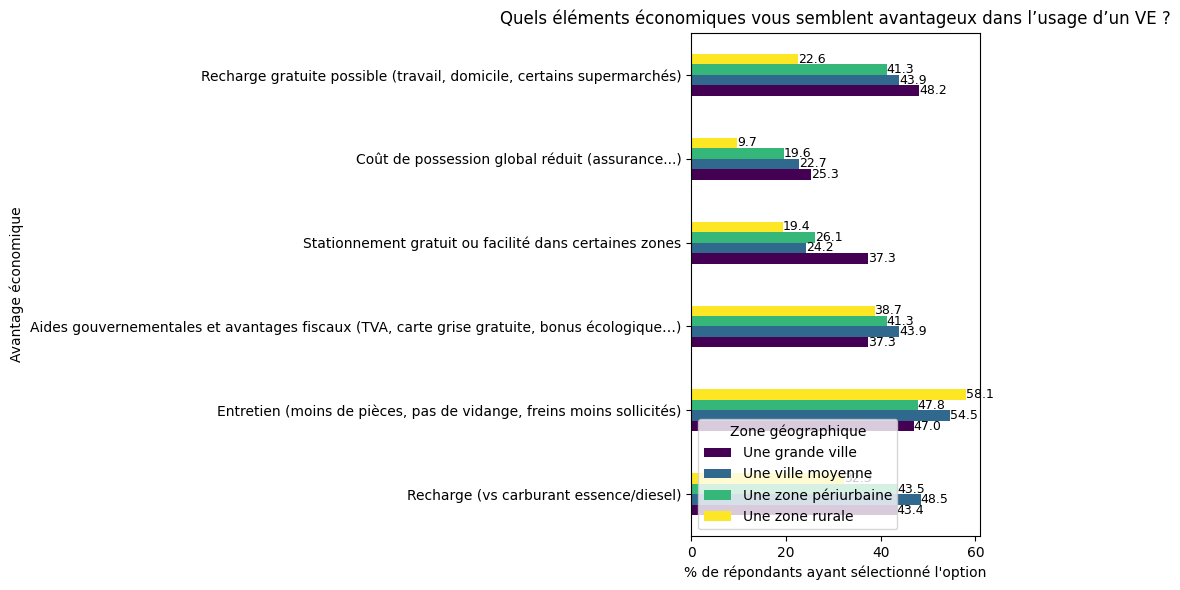

In [12]:
geo_col = "Habitez-vous dans :"
economic_cols = [
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge (vs carburant essence/diesel))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Entretien (moins de pièces, pas de vidange, freins moins sollicités))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Aides gouvernementales et avantages fiscaux (TVA, carte grise gratuite, bonus écologique…))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Stationnement gratuit ou facilité dans certaines zones)',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Coût de possession global réduit (assurance...))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge gratuite possible (travail, domicile, certains supermarchés))',
]

# Regrouper les réponses par origine géographique
grouped = df.groupby(geo_col)[economic_cols].mean().transpose()

# Mise en forme en pourcentage
grouped_percent = grouped * 100

# Récupérer les labels et le titre pour l'axe Y et le titre du graphique
labels, title = get_labels_and_title(grouped_percent.index)

# Affichage chiffré sous forme de tableau (DataFrame)
print(f"📊 Pourcentage de répondants par zone ayant sélectionné chaque avantage ({title}):")

grouped_percent_labeled = grouped_percent.copy()
grouped_percent_labeled.index = labels
display(grouped_percent_labeled.round(1))

# Graphique
ax = grouped_percent.plot(kind='barh', figsize=(10, 6), colormap='viridis')
plt.title(title)
plt.xlabel("% de répondants ayant sélectionné l'option")
plt.ylabel("Avantage économique")
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.legend(title="Zone géographique")
plt.tight_layout()

# Ajout des valeurs sur chaque barre
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge', fontsize=9)

plt.show()


**Perceived economic advantages of EVs by area of residence:**

| Economic advantage                  | Large city | Medium city | Suburban | Rural   |
|-------------------------------------|------------|-------------|----------|---------|
| Lower fuel cost                     | 43.4%      | 48.5%       | 43.5%    | 32.3%   |
| Lower maintenance                   | 47.0%      | 54.5%       | 47.8%    | 58.1%   |
| Governmental subsidies/tax benefits | 37.3%      | 43.9%       | 41.3%    | 38.7%   |
| Free/easier parking                 | 37.3%      | 24.2%       | 26.1%    | 19.4%   |
| Lower total cost of ownership       | 25.3%      | 22.7%       | 19.6%    | 9.7%    |
| Free charging (work, home, etc.)    | 48.2%      | 43.9%       | 41.3%    | 22.6%   |

---

**Key insights for analysis:**
- **Lower fuel cost is most recognized in medium cities (48.5%) and least in rural areas (32.3%).**
- **Lower maintenance is most cited in rural areas (58.1%),** suggesting rural respondents value tangible running cost savings.
- **Free/easier parking and free charging are much more recognized in large cities (37.3% and 48.2%) than in rural areas (19.4% and 22.6%),** reflecting greater policy visibility and infrastructure in urban settings.
- **Lower total cost of ownership is least cited in rural areas (9.7%),** indicating this argument may be less persuasive outside cities.
- **Interpretation:** Urban respondents are more likely to perceive indirect financial benefits (parking, charging), while rural respondents focus on direct savings (maintenance). This highlights the importance of tailoring communication about EV benefits to local context and infrastructure exposure.
- **Further analysis:** Exploring whether these perceived advantages translate into higher adoption intent by area could inform targeted policy and outreach strategies.

## Aid awareness

In [13]:
impact_col = "Est-ce que ces aides impactent votre envie d'adopter un véhicule électrique ?"
aides_col = "Connaissez-vous des aides financières disponibles pour l’achat d’un véhicule électrique ? (Cochez tout ce que vous connaissez)\n"

# Fonction robuste pour compter les aides connues
def count_aides(cell):
    if pd.isna(cell) or not cell.strip():
        return 0
    return len([aide.strip() for aide in cell.split(',') if aide.strip() and aide.strip().lower() != "aucune"])

# Création des colonnes
df['score_aides_connues'] = df[aides_col].apply(count_aides)
df['connait_aide'] = (df['score_aides_connues'] > 0).map({True: "Oui", False: "Non"})


if 'intention_adopter' in df.columns:
    ct = df.groupby(impact_col)['intention_adopter'].mean()
    print("Intention d'adopter (moyenne) selon impact perçu des aides :")
    display(ct.to_frame("Intention d'adopter (moyenne)"))

    # 2. Crosstab connaissance vs impact
    ct2 = pd.crosstab(df['connait_aide'], df[impact_col])
    prop2 = ct2.div(ct2.sum(axis=1), axis=0)

    print("\nRépartition de l'impact perçu selon connaissance des aides :")
    display(prop2.round(2))

    # Barplot proportionnel
    ax = prop2.plot(kind='bar', stacked=True, colormap='viridis', figsize=(7,5))
    plt.title("Impact perçu des aides selon connaissance")
    plt.xlabel("Connaît au moins une aide")
    plt.ylabel("Proportion")
    plt.legend(title="Impact perçu", bbox_to_anchor=(1.05, 1), loc='upper left')
    # Add value labels on each bar segment
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
    plt.tight_layout()
    plt.show()

    # Camembert uniquement pour ceux qui connaissent au moins une aide
    if "Oui" in prop2.index:
        plt.figure(figsize=(6, 6))
        plt.pie(
            prop2.loc["Oui"],
            labels=prop2.columns,
            autopct='%1.1f%%',
            startangle=90,
            colors=plt.cm.viridis(np.linspace(0.3, 0.85, len(prop2.columns))),
            textprops={'fontsize': 12}
        )
        plt.title("Impact perçu des aides (parmi ceux qui en connaissent)")
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()
        # Affichage des valeurs en format texte
        print("Répartition de l'impact perçu des aides (parmi ceux qui en connaissent) :")
        display(pd.DataFrame(prop2.loc[["Oui"]]).T.style.format("{:.2%}"))

    # 3. Test du Chi²
    chi2, p, dof, _ = chi2_contingency(ct2)
    print(f"\nTest du Chi² entre connaissance et impact perçu : p-value = {p:.4f}")

    # 4. Intention d'adopter en fonction du nombre d’aides connues
    adoption_by_aides = df.groupby('score_aides_connues')['intention_adopter'].mean()
    plt.figure(figsize=(7,4))
    ax = adoption_by_aides.plot(marker='o', color='darkorange')
    plt.xlabel("Nombre d'aides connues")
    plt.ylabel("Proportion d'adoption (intention_adopter)")
    plt.title("Intention d'adopter en fonction du nombre d'aides connues")
    plt.ylim(0, 1)
    plt.grid(True)
    # Add value labels on each point
    for i, (x, y) in enumerate(adoption_by_aides.items()):
        ax.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,8), ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    plt.tight_layout()
    plt.show()
    # Print the values in textual format
    print("Proportion d'adoption par nombre d'aides connues :")
    display(adoption_by_aides.round(2).to_frame("Proportion d'adoption"))





- **Adoption intent by perceived impact of aids:**
  - **Not impactful:** mean = **1.86**
  - **Vaguely impactful:** mean = **2.82**
  - **Impactful:** mean = **3.03**

- **Perceived impact of aids by knowledge (knows at least one aid):**
  - **"No" impact:** **43%**
  - **"Yes" impact:** **25%**
  - **"Vaguely" impact:** **32%**

- **Perceived impact of aids by knowledge (knows no aid):**
  - **"No" impact:** **51%**
  - **"Yes" impact:** **9%**
  - **"Vaguely" impact:** **40%**

- **Chi-square test:**  
  - **p-value = 0.0228** (significant association between knowing aids and perceived impact)


- **Adoption intent is much higher among those who perceive aids as impactful** (mean = 3.03) compared to those who do not (mean = 1.86).
- **Even partial perceived influence ("vaguely") is associated with a strong increase in adoption intent** (mean = 2.82).
- **Knowing at least one aid increases the likelihood of perceiving aids as impactful** (25% vs. 9% for those who know none).
- **However, a large share of respondents who know aids still say they have "no" impact** (43%), suggesting that simply knowing about aids is not enough—perceived usefulness is key.
- **Statistically significant association:** There is a significant link between knowing about aids and perceiving them as impactful (p = 0.0228).



- **Communication strategies should not only inform about available aids but also emphasize their concrete benefits and impact** to increase perceived usefulness and adoption intent.
- **Targeting people who know few or no aids with clear, impactful information could help shift their perception and increase adoption intent.**
- **Further analysis:** Explore which types of aids are most likely to be perceived as impactful, and whether this varies by demographic group.

In [20]:
from IPython.display import display

df['intention_adopter_ord'] = df[impact_col].map({
    "Totalement d'accord": 1,
    "Plutôt d'accord": 2,
    "Plutôt pas d'accord": 3,
    "Pas du tout d'accord": 4})
aides_col = "Connaissez-vous des aides financières disponibles pour l’achat d’un véhicule électrique ? (Cochez tout ce que vous connaissez)\n"

display(df['score_aides_connues'].describe().to_frame("Statistiques score_aides_connues"))

# Impact perçu des aides
aide_influence_col = "Est-ce que ces aides impactent votre envie d'adopter un véhicule électrique ?"
aide_influence_by_aides = df.groupby('score_aides_connues')[aide_influence_col].value_counts(normalize=True).unstack().fillna(0)
# Moyenne de l'intention d'adopter selon l'impact perçu des aides
mean_intention = df.groupby(aide_influence_col)['intention_adopter_ord'].mean()

# Affichage des valeurs en format tableau

print("Répartition des réponses sur l'impact perçu des aides selon le nombre d'aides connues :")
display(aide_influence_by_aides.round(2))


,Statistiques score_aides_connues
count,232.000000
mean,1.534483
std,1.385959
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,6.000000


Répartition des réponses sur l'impact perçu des aides selon le nombre d'aides connues :


Est-ce que ces aides impactent votre envie d'adopter un véhicule électrique ?,Non,Oui,Vaguement
score_aides_connues,,,
1,0.49,0.11,0.40
2,0.35,0.33,0.33
3,0.67,0.33,0.00
4,0.25,0.25,0.50
5,0.90,0.10,0.00
6,0.14,0.43,0.43



Key Figures

- **Knowledge of aids:**  
  - Respondents know on average **1.53 financial aids** (median = 1, max = 6).
- **Perceived impact of aids on adoption intent:**  
  - If aids are perceived as **not impactful**: **mean adoption intent = 1.86**  
  - If aids are perceived as **"vaguely" impactful**: **mean adoption intent = 2.82**  
  - If aids are perceived as **impactful**: **mean adoption intent = 3.03**

Distribution by Number of Aids Known

- For those who know **1 aid**:  
  - 49% say "No" impact, 11% "Yes", 40% "Vaguely"
- For those who know **2 aids**:  
  - 35% "No", 33% "Yes", 33% "Vaguely"
- For those who know **6 aids**:  
  - 14% "No", 43% "Yes", 43% "Vaguely"

Insights & Analysis

- **The more aids a respondent knows, the more likely they are to perceive these aids as impactful** on their willingness to adopt an EV (e.g., among those who know 6 aids, 43% say "Yes" vs. only 11% for those who know 1 aid).
- **Adoption intent is much higher among those who perceive aids as impactful** (mean = 3.03) compared to those who do not (mean = 1.86).
- **Intermediate effect:** Those who answer "Vaguely" are also more open to adoption (mean = 2.82), suggesting even partial perceived influence of aids can boost intent.
- **However, simply knowing more aids does not guarantee higher intent**—the perceived impact is the key driver.

Takeaways for Further Analysis

- **Communication strategies should not only inform about available aids but also emphasize their concrete benefits and impact** to increase perceived usefulness.
- **Targeting people who know few or no aids with clear, impactful information could help shift their perception and increase adoption intent.**
- **Further analysis:** Explore if certain types of aids (e.g., purchase subsidies vs. tax breaks) are more likely to be perceived as impactful, and whether this varies by demographic group.

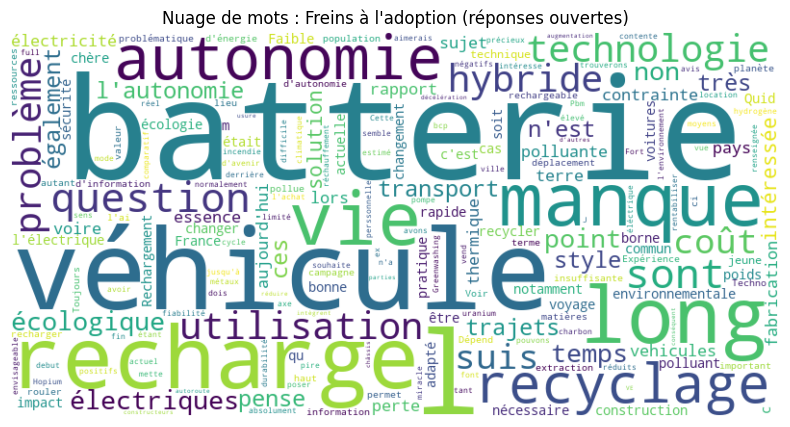

In [15]:
from wordcloud import WordCloud, STOPWORDS

# Liste de stopwords français de base
stopwords = set(STOPWORDS)
# Ajoute des mots spécifiques si besoin
stopwords.update([
    "les","je", "des", "aux", "avec", "pour", "dans", "sur", "par", "que", "qui", "une", "du", "en", "et", "le", "la", "un", "au", "ce", "se", "ne", "pas", "plus", "ou", "mais", "est", "à", "de", "il", "elle", "vous", "nous", "ils", "elles", "moi", "toi", "lui", "eux", "soi", "y", "en", "tout", "tous", "toutes", "bien", "mal", "comme", "si", "aussi", "sans", "sous", "avant", "après"
    "lors", "entre", "parce", "que", "quoi", "comment", "où", "quand", "pourquoi", "qui", "quel", "quelle", "lesquels", "lesquelles", "celui", "celle", "ceux", "celles", "cela", "ça", "ceci", "cela", "là", "ici", "là-bas", "ailleurs", "telle", "tellement", "tel", "tels", "telles", "tellement"
    "toute", "toutes", "tout", "tous", "chaque", "aucun", "aucune", "nul", "nulle", "rien", "personne", "quelqu'un", "quelque chose", "certains", "certaines", "plusieurs", "beaucoup", "trop", "assez", "peu", "moins","mon", "ton", "son", "notre", "votre", "leur", "ma", "ta", "sa", "mes", "tes", "ses", "nos", "vos", "leurs", "lui-même", "elle-même", "eux-mêmes", "elles-mêmes","électrique","encore","faire","voiture","plutôt","aussi","même","autre","autres","tous","toutes","quelque","quelques","quelques-uns","quelques-unes","certains","certaines","car","d","donc","alors","ainsi","tandis","pendant","lorsque","si","comme","parce que","puisque","bien que","quoique","malgré","sauf","excepté","au-delà de", "au lieu de", "à part", "en dehors de", "à l'exception de", "hormis", "sauf que", "excepté que", "mis à part", "sans compter que", "en plus de"
])

text = ' '.join(df["Pourquoi cette technologie ne vous intéresse pas ? Est-ce une question de valeurs, de style de vie, d'expériences ?\n"].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots : Freins à l'adoption (réponses ouvertes)")
plt.show()

## **multivariate (cross) analyses** 

Cluster profiles:


,cout_trop_cher,score_aides_connues,nb_avantages_economiques,intent_score,size
cluster,,,,,
0,0.777778,5.111111,2.888889,2.166667,18
1,1.000000,1.357895,2.400000,2.410526,95
2,-0.227273,1.295455,3.113636,2.613636,44


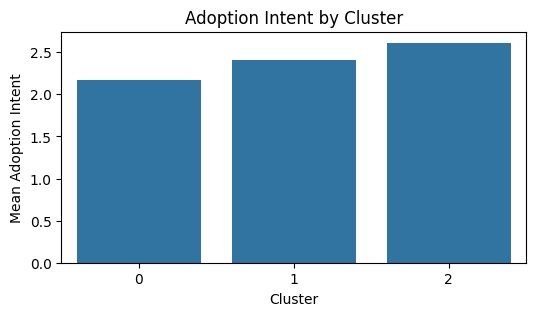

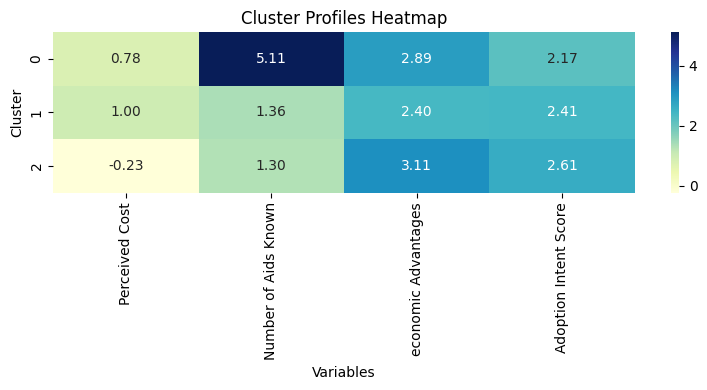

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

intent_map = {
    "Totalement en désaccord": 1,
    "Plutôt en désaccord": 2,
    "Plutôt d'accord": 3,
    "Totalement d'accord": 4
}
df["cout_trop_cher"] = df["Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?\n"].map({
    "Oui": 1,
    "Non": -1,
    "Je ne sais pas": 0
})
df['intent_score'] = df["Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"].map(intent_map)

cluster_vars = ['cout_trop_cher', 'score_aides_connues',  'nb_avantages_economiques', 'intent_score']
clust_data = df[cluster_vars].dropna().copy()
scaler = StandardScaler()
X_clust = scaler.fit_transform(clust_data)

kmeans = KMeans(n_clusters=3, random_state=42)
clust_labels = kmeans.fit_predict(X_clust)
clust_data['cluster'] = clust_labels

# Profile clusters
profile = clust_data.groupby('cluster').mean()
profile['size'] = clust_data['cluster'].value_counts().sort_index()
print("Cluster profiles:")
display(profile)

# Adoption intent by cluster
plt.figure(figsize=(6,3))
sns.barplot(x=profile.index, y=profile['intent_score'])
plt.xlabel("Cluster")
plt.ylabel("Mean Adoption Intent")
plt.title("Adoption Intent by Cluster")
plt.show()

# Rename columns for clarity
profile_renamed = profile.rename(columns={
    'cout_trop_cher': 'Perceived Cost',
    'score_aides_connues': 'Number of Aids Known',
    'nb_avantages_economiques': 'economic Advantages',
    'intent_score': 'Adoption Intent Score',
    'size': 'Size'
})

# Heatmap of cluster profiles (excluding 'Size' column)
plt.figure(figsize=(8,4))
sns.heatmap(profile_renamed.drop(columns='Size'), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Cluster Profiles Heatmap")
plt.xlabel("Variables")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


In [17]:
import statsmodels.formula.api as smf

# Use the actual column names in the formula
df["age_col"] = df[age_col]
df["geo_col"] = df[geo_col]
# Use Q("colname") for columns with spaces/special chars
ols_formula = f'score_aides_connues ~ C(Q("age_col")) + C(Q("geo_col"))'
print("OLS formula:", ols_formula)
ols_result = smf.ols(ols_formula, data=df).fit()
display(ols_result.summary())

# Create a numeric column for "Oui" response (1 if "Oui", 0 otherwise)
df["cost_too_expensive"] = (df['Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?\n'] == "Oui").astype(int)

logit_formula = 'cost_too_expensive ~ C(Q("age_col")) + C(Q("geo_col"))'
print("Logit formula:", logit_formula)
logit_result = smf.logit(logit_formula, data=df).fit()
display(logit_result.summary())


OLS formula: score_aides_connues ~ C(Q("age_col")) + C(Q("geo_col"))


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     score_aides_connues   R-squared:                       0.064
Model:                             OLS   Adj. R-squared:                  0.022
Method:                  Least Squares   F-statistic:                     1.519
Date:                 Sun, 25 May 2025   Prob (F-statistic):              0.134
Time:                         00:38:31   Log-Likelihood:                -396.70
No. Observations:                  232   AIC:                             815.4
Df Residuals:                      221   BIC:                             853.3
Df Model:                           10                                         
Covariance Type:             nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         1.6148      0.276      5.850      0.000       1.071       2.159
C(Q("age_col"))[T.35 à 44 ans]                   -0.4296      0.361     -1.191      0.235      -1.141       0.281
C(Q("age_col"))[T.45 à 54 ans]                   -0.5456      0.323     -1.687      0.093      -1.183       0.092
C(Q("age_col"))[T.55 à 64 ans]                   -0.4070      0.338     -1.204      0.230      -1.073       0.259
C(Q("age_col"))[T.65 à 74 ans]                   -0.6091      0.386     -1.579      0.116      -1.370       0.151
C(Q("age_col"))[T.75 ans et plus]                -0.2626      0.512     -0.512      0.609      -1.273       0.747
C(Q("age_col"))[T.Je ne préfère pas répondre]    -0.9169      1.402     -0.654      0.514      -3.679       1.846
C(Q("age_col"))[T.Moins de 25 ans]                0.3046      0.318      0.958      0.339      -0.322       0.931
C(Q("geo_col"))[T.Une ville moyenne]              0.3021      0.228      1.323      0.187      -0.148       0.752
C(Q("geo_col"))[T.Une zone périurbaine]           0.2413      0.257      0.939      0.349      -0.265       0.748
C(Q("geo_col"))[T.Une zone rurale]                0.1828      0.294      0.622      0.535      -0.397       0.762
==============================================================================
Omnibus:                       75.138   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.654
Skew:                           1.597   Prob(JB):                     5.83e-35
Kurtosis:                       5.472   Cond. No.                         18.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Logit formula: cost_too_expensive ~ C(Q("age_col")) + C(Q("geo_col"))
         Current function value: 0.529294
         Iterations: 35


c:\Users\Mango\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     cost_too_expensive   No. Observations:                  232
Model:                          Logit   Df Residuals:                      221
Method:                           MLE   Df Model:                           10
Date:                Sun, 25 May 2025   Pseudo R-squ.:                  0.1356
Time:                        00:38:31   Log-Likelihood:                -122.80
converged:                      False   LL-Null:                       -142.06
Covariance Type:            nonrobust   LLR p-value:                 3.077e-05
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -0.2819      0.426     -0.661      0.509      -1.118       0.554
C(Q("age_col"))[T.35 à 44 ans]                    1.0868      0.619      1.756      0.079      -0.126       2.300
C(Q("age_col"))[T.45 à 54 ans]                    0.3956      0.515      0.768      0.443      -0.614       1.406
C(Q("age_col"))[T.55 à 64 ans]                    1.2639      0.603      2.095      0.036       0.081       2.446
C(Q("age_col"))[T.65 à 74 ans]                    1.0666      0.693      1.538      0.124      -0.292       2.425
C(Q("age_col"))[T.75 ans et plus]                 1.2305      1.142      1.078      0.281      -1.007       3.468
C(Q("age_col"))[T.Je ne préfère pas répondre]    20.6330   4.35e+04      0.000      1.000   -8.52e+04    8.52e+04
C(Q("age_col"))[T.Moins de 25 ans]               -0.4119      0.490     -0.840      0.401      -1.373       0.549
C(Q("geo_col"))[T.Une ville moyenne]              1.0084      0.379      2.662      0.008       0.266       1.751
C(Q("geo_col"))[T.Une zone périurbaine]           1.2979      0.456      2.844      0.004       0.404       2.192
C(Q("geo_col"))[T.Une zone rurale]                1.5609      0.598      2.608      0.009       0.388       2.734
=================================================================================================================
"""